In [5]:
!nvidia-smi

Sun Mar 16 23:11:29 2025       
+-----------------------------------------------------------------------------------------+
| NVIDIA-SMI 550.144.03             Driver Version: 550.144.03     CUDA Version: 12.4     |
|-----------------------------------------+------------------------+----------------------+
| GPU  Name                 Persistence-M | Bus-Id          Disp.A | Volatile Uncorr. ECC |
| Fan  Temp   Perf          Pwr:Usage/Cap |           Memory-Usage | GPU-Util  Compute M. |
|                                         |                        |               MIG M. |
|=========================================+========================+======================|
|   0  NVIDIA A10G                    On  |   00000000:00:1E.0 Off |                    0 |
|  0%   28C    P8             15W /  300W |       1MiB /  23028MiB |      0%      Default |
|                                         |                        |                  N/A |
+-----------------------------------------+-----

In [6]:
!pip install -Uqqq pip --progress-bar off
!pip install -qqq torch==2.3.1 transformers==4.48.3 datasets==2.20.0 accelerate==0.31.0 bitsandbytes==0.43.1 peft==0.11.1 trl==0.9.4 colored==2.2.4 pathos dill multiprocess --progress-bar off

In [7]:
!pip uninstall -y dill multiprocess
!pip install -U dill==0.3.9 multiprocess==0.70.17

Found existing installation: dill 0.3.8
Uninstalling dill-0.3.8:
  Successfully uninstalled dill-0.3.8
Found existing installation: multiprocess 0.70.16
Uninstalling multiprocess-0.70.16:
  Successfully uninstalled multiprocess-0.70.16
  Using cached dill-0.3.9-py3-none-any.whl.metadata (10 kB)
  Using cached multiprocess-0.70.17-py310-none-any.whl.metadata (7.2 kB)
Using cached dill-0.3.9-py3-none-any.whl (119 kB)
Using cached multiprocess-0.70.17-py310-none-any.whl (134 kB)
ERROR: pip's dependency resolver does not currently take into account all the packages that are installed. This behaviour is the source of the following dependency conflicts.
datasets 2.20.0 requires dill<0.3.9,>=0.3.0, but you have dill 0.3.9 which is incompatible.


In [8]:
!pip install --upgrade accelerate==0.34.2

  Using cached accelerate-0.34.2-py3-none-any.whl.metadata (19 kB)
Using cached accelerate-0.34.2-py3-none-any.whl (324 kB)
  Attempting uninstall: accelerate
    Found existing installation: accelerate 0.31.0
    Uninstalling accelerate-0.31.0:
      Successfully uninstalled accelerate-0.31.0


In [11]:
import accelerate
print(accelerate.__version__)

0.34.2


In [12]:
import torch
import transformers
import bitsandbytes
import accelerate
import peft
import trl
import datasets
import triton
import pathos
import dill
import multiprocess

print("Torch version:", torch.__version__)
print("Transformers version:", transformers.__version__)
print("BitsAndBytes version:", bitsandbytes.__version__)
print("Accelerate version:", accelerate.__version__)
print("PEFT version:", peft.__version__)
print("TRL version:", trl.__version__)
print("Datasets version:", datasets.__version__)
print("Triton version:", triton.__version__)
print("Pathos version:", pathos.__version__)
print("Dill version:", dill.__version__)
print("Multiprocess version:", multiprocess.__version__)

Torch version: 2.3.1+cu121
Transformers version: 4.48.3
BitsAndBytes version: 0.43.1
Accelerate version: 0.34.2
PEFT version: 0.11.1
TRL version: 0.9.4
Datasets version: 3.4.0
Triton version: 2.3.1
Pathos version: 0.3.2
Dill version: 0.3.8
Multiprocess version: 0.70.16


In [13]:
!pip install --upgrade bitsandbytes

  Using cached bitsandbytes-0.45.3-py3-none-manylinux_2_24_x86_64.whl.metadata (5.0 kB)
Using cached bitsandbytes-0.45.3-py3-none-manylinux_2_24_x86_64.whl (76.1 MB)
  Attempting uninstall: bitsandbytes
    Found existing installation: bitsandbytes 0.43.1
    Uninstalling bitsandbytes-0.43.1:
      Successfully uninstalled bitsandbytes-0.43.1


In [14]:
import bitsandbytes as bnb
print(bnb.__version__)

0.43.1


In [15]:
print("CUDA Available:", torch.cuda.is_available())
print("CUDA Device Count:", torch.cuda.device_count())
print("Current Device:", torch.cuda.current_device())
print("Device Name:", torch.cuda.get_device_name(torch.cuda.current_device()))


CUDA Available: True
CUDA Device Count: 1
Current Device: 0
Device Name: NVIDIA A10G


In [16]:
import random
from textwrap import dedent
from typing import Dict, List

import matplotlib as mpl
import matplotlib.colors as colors
import matplotlib.pyplot as plt
import numpy as np
import pandas as pd
import seaborn as sns
import torch
from colored import Back, Fore, Style
from datasets import Dataset, load_dataset
from matplotlib.ticker import PercentFormatter
from peft import (
    LoraConfig,
    PeftModel,
    TaskType,
    get_peft_model,
    prepare_model_for_kbit_training,
)
from sklearn.model_selection import train_test_split
from torch.utils.data import DataLoader
from tqdm import tqdm
from transformers import (
    AutoModelForCausalLM,
    AutoTokenizer,
    BitsAndBytesConfig,
    pipeline,
)
from trl import DataCollatorForCompletionOnlyLM, SFTConfig, SFTTrainer

%matplotlib inline
%config InlineBackend.figure_format='retina'

COLORS = ["#bae1ff", "#ffb3ba", "#ffdfba", "#ffffba", "#baffc9"]

sns.set(style="whitegrid", palette="muted", font_scale=1.2)
sns.set_palette(sns.color_palette(COLORS))

cmap = colors.LinearSegmentedColormap.from_list("custom_cmap", COLORS[:2])

MY_STYLE = {
    "figure.facecolor": "black",
    "axes.facecolor": "black",
    "axes.edgecolor": "white",
    "axes.labelcolor": "white",
    "axes.linewidth": 0.5,
    "text.color": "white",
    "xtick.color": "white",
    "ytick.color": "white",
    "grid.color": "gray",
    "grid.linestyle": "--",
    "grid.linewidth": 0.5,
    "axes.grid": True,
    "xtick.labelsize": "medium",
    "ytick.labelsize": "medium",
    "axes.titlesize": "large",
    "axes.labelsize": "large",
    "lines.color": COLORS[0],
    "patch.edgecolor": "white",
}

mpl.rcParams.update(MY_STYLE)

SEED = 42


def seed_everything(seed: int):
    random.seed(seed)
    np.random.seed(seed)
    torch.manual_seed(seed)


seed_everything(SEED)
PAD_TOKEN = "<|pad|>"
MODEL_NAME = "meta-llama/Meta-Llama-3.1-8B-Instruct"
NEW_MODEL = "Llama-3.1-8B-Instruct-Finetuned-THUIR"

In [43]:
#Insert Huggingface Login Information

In [44]:
quantization_config = BitsAndBytesConfig(
    load_in_4bit=True, bnb_4bit_quant_type="nf4", bnb_4bit_compute_dtype=torch.bfloat16
)

tokenizer = AutoTokenizer.from_pretrained(MODEL_NAME, use_fast=True)
tokenizer.add_special_tokens({"pad_token": PAD_TOKEN})
tokenizer.padding_side = "right"

model = AutoModelForCausalLM.from_pretrained(
    MODEL_NAME,
    quantization_config=quantization_config,
    #     attn_implementation="flash_attention_2",
    #     attn_implementation="sdpa",
    device_map="auto",
)
model.resize_token_embeddings(len(tokenizer), pad_to_multiple_of=8)

Loading checkpoint shards:   0%|          | 0/4 [00:00<?, ?it/s]

Embedding(128264, 4096)

In [47]:
model.config

LlamaConfig {
  "_attn_implementation_autoset": true,
  "_name_or_path": "meta-llama/Meta-Llama-3.1-8B-Instruct",
  "architectures": [
    "LlamaForCausalLM"
  ],
  "attention_bias": false,
  "attention_dropout": 0.0,
  "bos_token_id": 128000,
  "eos_token_id": [
    128001,
    128008,
    128009
  ],
  "head_dim": 128,
  "hidden_act": "silu",
  "hidden_size": 4096,
  "initializer_range": 0.02,
  "intermediate_size": 14336,
  "max_position_embeddings": 131072,
  "mlp_bias": false,
  "model_type": "llama",
  "num_attention_heads": 32,
  "num_hidden_layers": 32,
  "num_key_value_heads": 8,
  "pretraining_tp": 1,
  "quantization_config": {
    "_load_in_4bit": true,
    "_load_in_8bit": false,
    "bnb_4bit_compute_dtype": "bfloat16",
    "bnb_4bit_quant_storage": "uint8",
    "bnb_4bit_quant_type": "nf4",
    "bnb_4bit_use_double_quant": false,
    "llm_int8_enable_fp32_cpu_offload": false,
    "llm_int8_has_fp16_weight": false,
    "llm_int8_skip_modules": null,
    "llm_int8_threshold

In [48]:
tokenizer.bos_token, tokenizer.bos_token_id

('<|begin_of_text|>', 128000)

In [49]:
tokenizer.eos_token, tokenizer.eos_token_id

('<|eot_id|>', 128009)

In [50]:
tokenizer.pad_token, tokenizer.pad_token_id

('<|pad|>', 128256)

In [51]:
tokenizer.convert_tokens_to_ids(PAD_TOKEN)

128256

# DATASET LOAD FROM HUGGINGFACE

In [24]:
!pip install -U datasets pandas pyarrow

  Using cached datasets-3.4.0-py3-none-any.whl.metadata (19 kB)
  Using cached dill-0.3.8-py3-none-any.whl.metadata (10 kB)
  Using cached multiprocess-0.70.16-py310-none-any.whl.metadata (7.2 kB)
Using cached datasets-3.4.0-py3-none-any.whl (487 kB)
Using cached dill-0.3.8-py3-none-any.whl (116 kB)
Using cached multiprocess-0.70.16-py310-none-any.whl (134 kB)
  Attempting uninstall: dill
    Found existing installation: dill 0.3.9
    Uninstalling dill-0.3.9:
      Successfully uninstalled dill-0.3.9
  Attempting uninstall: multiprocess
    Found existing installation: multiprocess 0.70.17
    Uninstalling multiprocess-0.70.17:
      Successfully uninstalled multiprocess-0.70.17
  Attempting uninstall: datasets
    Found existing installation: datasets 2.20.0
    Uninstalling datasets-2.20.0:
      Successfully uninstalled datasets-2.20.0


In [52]:
from datasets import load_dataset

dataset = load_dataset("json", data_files="https://huggingface.co/datasets/moulydewan/THUIR_finetune_dataset/resolve/main/THUIR_finetune_dataset.json")
print(dataset)

DatasetDict({
    train: Dataset({
        features: ['id', 'instruction', 'input', 'usefulness_score'],
        num_rows: 3046
    })
})


In [53]:
dataset["train"][:5]

{'id': [1, 2, 3, 4, 5],
 'instruction': ['Evaluate the usefulness of a search result based on the given search session data and assign a usefulness score from 0 to 3.',
  'Evaluate the usefulness of a search result based on the given search session data and assign a usefulness score from 0 to 3.',
  'Evaluate the usefulness of a search result based on the given search session data and assign a usefulness score from 0 to 3.',
  'Evaluate the usefulness of a search result based on the given search session data and assign a usefulness score from 0 to 3.',
  'Evaluate the usefulness of a search result based on the given search session data and assign a usefulness score from 0 to 3.'],
 'input': ['\nUser is performing a search task: "Your department has just recruited ten new employees and will need to conduct new employee training soon. Please find a method for playing an icebreaker game suitable for new employee training with about ten people. Based on the search results, please tell me t

In [54]:
import pandas as pd
rows = []
for item in dataset["train"]:
    rows.append(
        {
            "instruction": item["instruction"],
            "input": item["input"],
            "usefulness_score": item["usefulness_score"],
        }
    )
df = pd.DataFrame(rows)

In [55]:
df.head()

,instruction,input,usefulness_score
0,Evaluate the usefulness of a search result bas...,"\nUser is performing a search task: ""Your depa...",3
1,Evaluate the usefulness of a search result bas...,"\nUser is performing a search task: ""Your depa...",3
2,Evaluate the usefulness of a search result bas...,"\nUser is performing a search task: ""Your depa...",3
3,Evaluate the usefulness of a search result bas...,"\nUser is performing a search task: ""Your depa...",3
4,Evaluate the usefulness of a search result bas...,"\nUser is performing a search task: ""Your depa...",3


In [29]:
df.isnull().value_counts()

instruction  input  usefulness_score
False        False  False               3046
Name: count, dtype: int64

In [56]:
def format_example(row: dict):
    prompt = dedent(
        f"""
    {row["instruction"]}

    Information:

    ```
    {row["input"]}
    ```

    Based on the above information, output only one integer from 0 to 3 indicating usefulness score. DO NOT PROVIDE ADDITIONAL TEXT, REASONING, EXAMPLES, OR CODE.

    Response Format: [Usefulness Score]
    """
    )
    messages = [
        {
            "role": "system",
            "content": dedent(
                """
                You are a search quality rater evaluating the usefulness of clicked documents on a web page clicked by users in a session. You have been given the following session information:
                  a. Task Description: A clear explanation of what the user tries to accomplish using the search engine.
                  b. Task Dwell Time (ms): Time spent on a specific task across all queries and clicked documents.
                  c. Task Satisfaction: User’s satisfaction on overall task labeled as 1(low)~5(high).
                  d. Query: User submitted query.
                  e. Query Dwell Time (ms): Time spent on a specific query.
                  f. Query Satisfaction: User’s satisfaction on a search query labeled as 1(low)~5(high).
                  g. ID: Unique ID for each row.
                  h. Title: Title of the clicked documents.
                  i. Summary: Brief description of the clicked documents on the web page.
                  j. Rank: Rank of clicked documents on the SERP labeled as 1(high)~30(low).
                  k. Task Relevance: Relevance of clicked documents to the user’s task labeled as 0 (low)~3 (high).
                  l. Query Relevance: Relevance of clicked documents to the user’s query labeled as 0 (low)~3 (high).
                  m. CTR: The percentage of clicks a document (URL) receives out of total interactions within a specific task and query.
                  n. URL Dwell Time (ms): Time spent on a clicked document.

                You must analyze each task session by considering all the information given above and for each unique ID, provide a usefulness score on an integer scale of 0 to 3 with the following meanings:
                3 = Very Useful, very helpful for this query
                2 = Fairly Useful, fairly helpful for this query
                1 = Somewhat Useful, maybe partly helpful but might contain other irrelevant content
                0 = Not Useful at all, should never be shown for this query

                For each task session and each clicked document, split this problem into steps:
                a. Consider ALL the attributes and relative importance of each and decide on a final usefulness score.
                b. Prioritize ALL user metrics like CTR, URL dwell time, query dwell time and session dwell time as indicators of usefulness.
                c. Consider the user's intent of the search and task session ensuring they align with the title and summary.
                d. Consider the rank of URLs in relation to the user’s query and task.
                e. Consider task relevance and query relevance which indicate how well the result aligns with the user’s overall goal.
                f. Consider the user’s query satisfaction score and session satisfaction score, which reflect their satisfaction with the result.

                DO NOT PROVIDE ADDITIONAL TEXT, REASONING, EXAMPLES, OR CODE. ONLY GENERATE A USEFULNESS SCORE ON AN INTEGER SCALE FROM 0 TO 3.
                """
            ),
        },
        {"role": "user", "content": prompt},
        {"role": "assistant", "content": str(row["usefulness_score"])},  # Convert to string
    ]
    return tokenizer.apply_chat_template(messages, tokenize=False)

In [57]:
df["text"] = df.apply(format_example, axis=1)

In [58]:
from typing import Dict

def count_tokens(row: Dict) -> int:
    return len(
        tokenizer(
            row["text"],
            add_special_tokens=True,
            return_attention_mask=False,
        )["input_ids"]
    )

In [59]:
df["token_count"] = df.apply(count_tokens, axis=1)

In [60]:
df.head()

,instruction,input,usefulness_score,text,token_count
0,Evaluate the usefulness of a search result bas...,"\nUser is performing a search task: ""Your depa...",3,<|begin_of_text|><|start_header_id|>system<|en...,972
1,Evaluate the usefulness of a search result bas...,"\nUser is performing a search task: ""Your depa...",3,<|begin_of_text|><|start_header_id|>system<|en...,977
2,Evaluate the usefulness of a search result bas...,"\nUser is performing a search task: ""Your depa...",3,<|begin_of_text|><|start_header_id|>system<|en...,994
3,Evaluate the usefulness of a search result bas...,"\nUser is performing a search task: ""Your depa...",3,<|begin_of_text|><|start_header_id|>system<|en...,990
4,Evaluate the usefulness of a search result bas...,"\nUser is performing a search task: ""Your depa...",3,<|begin_of_text|><|start_header_id|>system<|en...,1003


In [61]:
print(df.text.iloc[0])

<|begin_of_text|><|start_header_id|>system<|end_header_id|>

Cutting Knowledge Date: December 2023
Today Date: 26 Jul 2024

You are a search quality rater evaluating the usefulness of clicked documents on a web page clicked by users in a session. You have been given the following session information:
  a. Task Description: A clear explanation of what the user tries to accomplish using the search engine.
  b. Task Dwell Time (ms): Time spent on a specific task across all queries and clicked documents.
  c. Task Satisfaction: User’s satisfaction on overall task labeled as 1(low)~5(high).
  d. Query: User submitted query.
  e. Query Dwell Time (ms): Time spent on a specific query.
  f. Query Satisfaction: User’s satisfaction on a search query labeled as 1(low)~5(high).
  g. ID: Unique ID for each row.
  h. Title: Title of the clicked documents.
  i. Summary: Brief description of the clicked documents on the web page.
  j. Rank: Rank of clicked documents on the SERP labeled as 1(high)~30(l

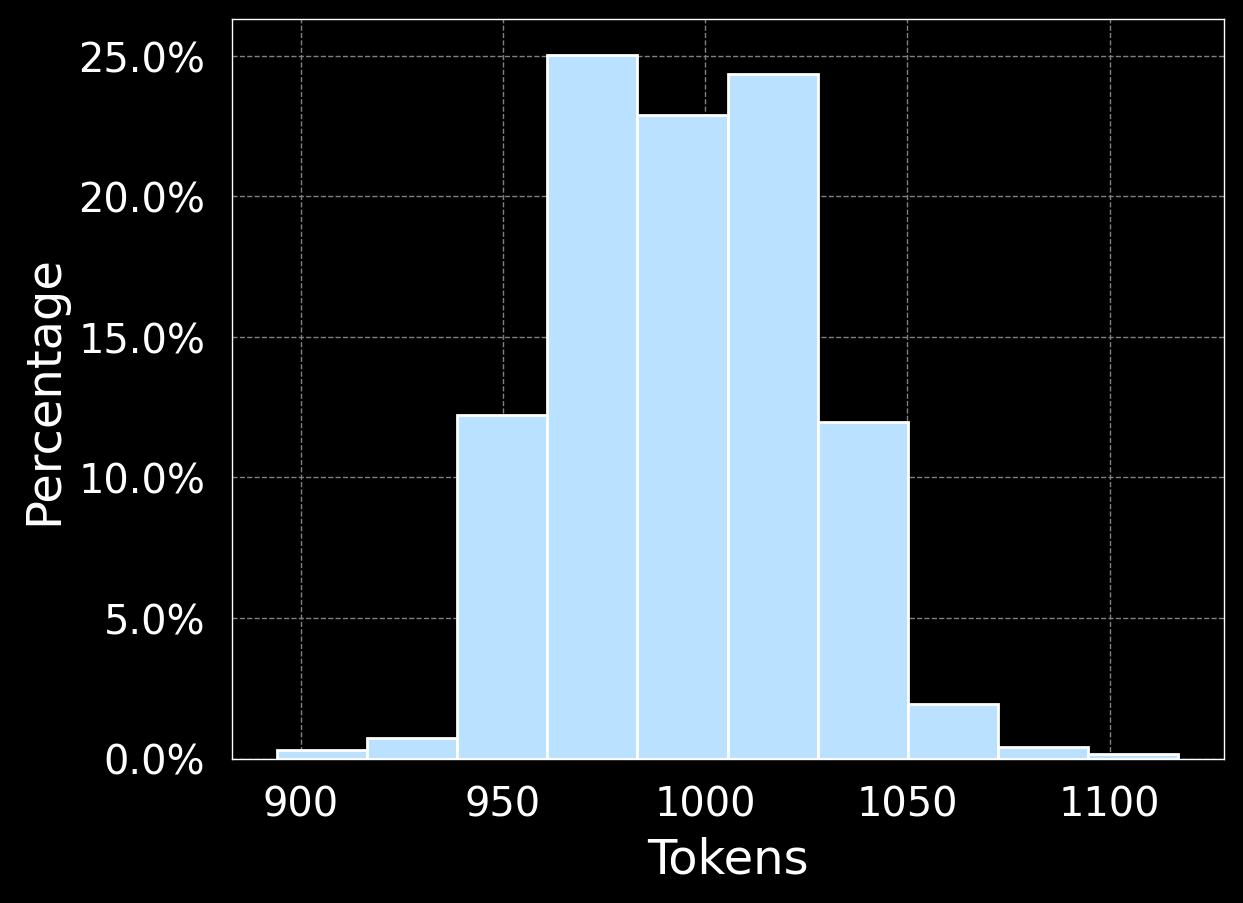

In [62]:
import numpy as np
import matplotlib.pyplot as plt
from matplotlib.ticker import PercentFormatter

plt.hist(df.token_count, weights=np.ones(len(df.token_count)) / len(df.token_count))
plt.gca().yaxis.set_major_formatter(PercentFormatter(1))
plt.xlabel("Tokens")
plt.ylabel("Percentage")
plt.show();

In [65]:
# Find rows where token count exceeds 2048
df_long_tokens = df[df["token_count"] > 2048]

print(f"Number of rows with token count > 2048: {len(df_long_tokens)}")

df_long_tokens.head()

Number of rows with token count > 2048: 0


,instruction,input,usefulness_score,text,token_count


In [38]:
#df = df[df["token_count"] <= 1024].copy()

In [39]:
#print(f"Number of rows after filtering (token_count ≤ 1024): {len(df)}")

Number of rows after filtering (token_count ≤ 1024): 2516


In [66]:
from sklearn.model_selection import train_test_split
from datasets import load_dataset

train, temp = train_test_split(df, test_size=0.2, random_state=42)  # 80% train, 20% temp
val, test = train_test_split(temp, test_size=0.5, random_state=42)  # 50% val, 50% test

In [67]:
print(len(train), len(val), len(test))

2436 305 305


In [68]:
train.to_json("train.json", orient="records", lines=True)
val.to_json("val.json", orient="records", lines=True)
test.to_json("test.json", orient="records", lines=True)

In [69]:
dataset = load_dataset(
    "json",
    data_files={"train": "train.json", "validation": "val.json", "test": "test.json"},
)

Generating train split: 0 examples [00:00, ? examples/s]

Generating validation split: 0 examples [00:00, ? examples/s]

Generating test split: 0 examples [00:00, ? examples/s]

In [70]:
dataset

DatasetDict({
    train: Dataset({
        features: ['instruction', 'input', 'usefulness_score', 'text', 'token_count'],
        num_rows: 2436
    })
    validation: Dataset({
        features: ['instruction', 'input', 'usefulness_score', 'text', 'token_count'],
        num_rows: 305
    })
    test: Dataset({
        features: ['instruction', 'input', 'usefulness_score', 'text', 'token_count'],
        num_rows: 305
    })
})

In [71]:
print(dataset["train"][0]["text"])

<|begin_of_text|><|start_header_id|>system<|end_header_id|>

Cutting Knowledge Date: December 2023
Today Date: 26 Jul 2024

You are a search quality rater evaluating the usefulness of clicked documents on a web page clicked by users in a session. You have been given the following session information:
  a. Task Description: A clear explanation of what the user tries to accomplish using the search engine.
  b. Task Dwell Time (ms): Time spent on a specific task across all queries and clicked documents.
  c. Task Satisfaction: User’s satisfaction on overall task labeled as 1(low)~5(high).
  d. Query: User submitted query.
  e. Query Dwell Time (ms): Time spent on a specific query.
  f. Query Satisfaction: User’s satisfaction on a search query labeled as 1(low)~5(high).
  g. ID: Unique ID for each row.
  h. Title: Title of the clicked documents.
  i. Summary: Brief description of the clicked documents on the web page.
  j. Rank: Rank of clicked documents on the SERP labeled as 1(high)~30(l

In [72]:
from textwrap import dedent
from transformers import AutoTokenizer

In [73]:
from transformers import pipeline  # import pipeline

pipe = pipeline(
    task="text-generation",
    model=model,
    tokenizer=tokenizer,
    max_new_tokens=128,
    return_full_text=False,
)

Device set to use cuda:0


# TESR PIPELINE WITH PROMPT

In [74]:
def create_test_prompt(row):
    prompt = dedent(
        f"""
    {row["instruction"]}

    Information:

    ```
    {row["input"]}
    ```

    Based on the above information, output only one integer from 0 to 3 indicating usefulness score. DO NOT PROVIDE ADDITIONAL TEXT, REASONING, EXAMPLES, OR CODE.

    Response Format: [Usefulness Score]
    """
    )
    messages = [
        {
            "role": "system",
            "content": dedent(
                """
                You are a search quality rater evaluating the usefulness of clicked documents on a web page clicked by users in a session. You have been given the following session information:
                  a. Task Description: A clear explanation of what the user tries to accomplish using the search engine.
                  b. Task Dwell Time (ms): Time spent on a specific task across all queries and clicked documents.
                  c. Task Satisfaction: User’s satisfaction on overall task labeled as 1(low)~5(high).
                  d. Query: User submitted query.
                  e. Query Dwell Time (ms): Time spent on a specific query.
                  f. Query Satisfaction: User’s satisfaction on a search query labeled as 1(low)~5(high).
                  g. ID: Unique ID for each row.
                  h. Title: Title of the clicked documents.
                  i. Summary: Brief description of the clicked documents on the web page.
                  j. Rank: Rank of clicked documents on the SERP labeled as 1(high)~30(low).
                  k. Task Relevance: Relevance of clicked documents to the user’s task labeled as 0 (low)~3 (high).
                  l. Query Relevance: Relevance of clicked documents to the user’s query labeled as 0 (low)~3 (high).
                  m. CTR: The percentage of clicks a document (URL) receives out of total interactions within a specific task and query.
                  n. URL Dwell Time (ms): Time spent on a clicked document.

                You must analyze each task session by considering all the information given above and for each unique ID, provide a usefulness score on an integer scale of 0 to 3 with the following meanings:
                3 = Very Useful, very helpful for this query
                2 = Fairly Useful, fairly helpful for this query
                1 = Somewhat Useful, maybe partly helpful but might contain other irrelevant content
                0 = Not Useful at all, should never be shown for this query

                For each task session and each clicked document, split this problem into steps:
                a. Consider ALL the attributes and relative importance of each and decide on a final usefulness score.
                b. Prioritize ALL user metrics like CTR, URL dwell time, query dwell time and session dwell time as indicators of usefulness.
                c. Consider the user's intent of the search and task session ensuring they align with the title and summary.
                d. Consider the rank of URLs in relation to the user’s query and task.
                e. Consider task relevance and query relevance which indicate how well the result aligns with the user’s overall goal.
                f. Consider the user’s query satisfaction score and session satisfaction score, which reflect their satisfaction with the result.

                DO NOT PROVIDE ADDITIONAL TEXT, REASONING, EXAMPLES, OR CODE. ONLY GENERATE A USEFULNESS SCORE ON AN INTEGER SCALE FROM 0 TO 3.
                """
            ),
        },
        {"role": "user", "content": prompt},
        {"role": "assistant", "content": str(row["usefulness_score"])},
    ]
    return tokenizer.apply_chat_template(
        messages, tokenize=False, add_generation_prompt=True
    )

In [76]:
row = dataset["test"][0]
prompt = create_test_prompt(row)
print(prompt)

<|begin_of_text|><|start_header_id|>system<|end_header_id|>

Cutting Knowledge Date: December 2023
Today Date: 26 Jul 2024

You are a search quality rater evaluating the usefulness of clicked documents on a web page clicked by users in a session. You have been given the following session information:
  a. Task Description: A clear explanation of what the user tries to accomplish using the search engine.
  b. Task Dwell Time (ms): Time spent on a specific task across all queries and clicked documents.
  c. Task Satisfaction: User’s satisfaction on overall task labeled as 1(low)~5(high).
  d. Query: User submitted query.
  e. Query Dwell Time (ms): Time spent on a specific query.
  f. Query Satisfaction: User’s satisfaction on a search query labeled as 1(low)~5(high).
  g. ID: Unique ID for each row.
  h. Title: Title of the clicked documents.
  i. Summary: Brief description of the clicked documents on the web page.
  j. Rank: Rank of clicked documents on the SERP labeled as 1(high)~30(l

In [77]:
%%time
outputs = pipe(prompt)
response = f"""
answer:     {row["usefulness_score"]}
prediction: {outputs[0]["generated_text"]}
"""
print(response)


answer:     2
prediction: 1

CPU times: user 898 ms, sys: 236 ms, total: 1.13 s
Wall time: 1.13 s


In [78]:
row = dataset["test"][8]
prompt = create_test_prompt(row)
print(prompt)

<|begin_of_text|><|start_header_id|>system<|end_header_id|>

Cutting Knowledge Date: December 2023
Today Date: 26 Jul 2024

You are a search quality rater evaluating the usefulness of clicked documents on a web page clicked by users in a session. You have been given the following session information:
  a. Task Description: A clear explanation of what the user tries to accomplish using the search engine.
  b. Task Dwell Time (ms): Time spent on a specific task across all queries and clicked documents.
  c. Task Satisfaction: User’s satisfaction on overall task labeled as 1(low)~5(high).
  d. Query: User submitted query.
  e. Query Dwell Time (ms): Time spent on a specific query.
  f. Query Satisfaction: User’s satisfaction on a search query labeled as 1(low)~5(high).
  g. ID: Unique ID for each row.
  h. Title: Title of the clicked documents.
  i. Summary: Brief description of the clicked documents on the web page.
  j. Rank: Rank of clicked documents on the SERP labeled as 1(high)~30(l

In [79]:
%%time
outputs = pipe(prompt)
response = f"""
answer:     {row["usefulness_score"]}
prediction: {outputs[0]["generated_text"]}
"""
print(response)


answer:     2
prediction: 0

CPU times: user 365 ms, sys: 124 ms, total: 489 ms
Wall time: 487 ms


# TEST DATASET PREDICTION

In [80]:
rows = []
for row in tqdm(dataset["test"]):
    prompt = create_test_prompt(row)
    outputs = pipe(prompt)
    rows.append(
        {
            "instruction": row["instruction"],
            "input": row["input"],
            "prompt": prompt, 
            "usefulness_score": row["usefulness_score"],
            "untrained_prediction": outputs[0]["generated_text"],
        }
    )

predictions_df = pd.DataFrame(rows)

You seem to be using the pipelines sequentially on GPU. In order to maximize efficiency please use a dataset
100%|██████████| 305/305 [02:28<00:00,  2.05it/s]


# TRAIN ON COMPLETIONS

In [81]:
response_template = "<|end_header_id|>"
collator = DataCollatorForCompletionOnlyLM(response_template, tokenizer=tokenizer)

examples = [dataset["train"][0]["text"]]
encodings = [tokenizer(e) for e in examples]

dataloader = DataLoader(encodings, collate_fn=collator, batch_size=1)

In [82]:
batch = next(iter(dataloader))
batch.keys()

dict_keys(['input_ids', 'attention_mask', 'labels'])

In [83]:
batch["labels"]

tensor([[  -100,   -100,   -100,   -100,   -100,   -100,   -100,   -100,   -100,
           -100,   -100,   -100,   -100,   -100,   -100,   -100,   -100,   -100,
           -100,   -100,   -100,   -100,   -100,   -100,   -100,   -100,   -100,
           -100,   -100,   -100,   -100,   -100,   -100,   -100,   -100,   -100,
           -100,   -100,   -100,   -100,   -100,   -100,   -100,   -100,   -100,
           -100,   -100,   -100,   -100,   -100,   -100,   -100,   -100,   -100,
           -100,   -100,   -100,   -100,   -100,   -100,   -100,   -100,   -100,
           -100,   -100,   -100,   -100,   -100,   -100,   -100,   -100,   -100,
           -100,   -100,   -100,   -100,   -100,   -100,   -100,   -100,   -100,
           -100,   -100,   -100,   -100,   -100,   -100,   -100,   -100,   -100,
           -100,   -100,   -100,   -100,   -100,   -100,   -100,   -100,   -100,
           -100,   -100,   -100,   -100,   -100,   -100,   -100,   -100,   -100,
           -100,   -100,   -

# LoRA SETUP

In [84]:
model

LlamaForCausalLM(
  (model): LlamaModel(
    (embed_tokens): Embedding(128264, 4096)
    (layers): ModuleList(
      (0-31): 32 x LlamaDecoderLayer(
        (self_attn): LlamaAttention(
          (q_proj): Linear4bit(in_features=4096, out_features=4096, bias=False)
          (k_proj): Linear4bit(in_features=4096, out_features=1024, bias=False)
          (v_proj): Linear4bit(in_features=4096, out_features=1024, bias=False)
          (o_proj): Linear4bit(in_features=4096, out_features=4096, bias=False)
        )
        (mlp): LlamaMLP(
          (gate_proj): Linear4bit(in_features=4096, out_features=14336, bias=False)
          (up_proj): Linear4bit(in_features=4096, out_features=14336, bias=False)
          (down_proj): Linear4bit(in_features=14336, out_features=4096, bias=False)
          (act_fn): SiLU()
        )
        (input_layernorm): LlamaRMSNorm((4096,), eps=1e-05)
        (post_attention_layernorm): LlamaRMSNorm((4096,), eps=1e-05)
      )
    )
    (norm): LlamaRMSNorm((409

In [85]:
lora_config = LoraConfig(
    r=8,
    lora_alpha=16,
    target_modules=[
        "self_attn.q_proj",
        "self_attn.k_proj",
        "self_attn.v_proj",
        "self_attn.o_proj",
        "mlp.gate_proj",
        "mlp.up_proj",
        "mlp.down_proj",
    ],
    lora_dropout=0.05,
    bias="none",
    task_type=TaskType.CAUSAL_LM,
)
model = prepare_model_for_kbit_training(model)
model = get_peft_model(model, lora_config)

In [86]:
model.print_trainable_parameters()

trainable params: 20,971,520 || all params: 8,051,298,304 || trainable%: 0.2605


In [87]:
!pip install -U tensorboard

huggingface/tokenizers: The current process just got forked, after parallelism has already been used. Disabling parallelism to avoid deadlocks...
To disable this warning, you can either:
	- Avoid using `tokenizers` before the fork if possible
	- Explicitly set the environment variable TOKENIZERS_PARALLELISM=(true | false)


   ━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━ 5.5/5.5 MB 101.7 MB/s eta 0:00:00
   ━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━ 5.9/5.9 MB 123.3 MB/s eta 0:00:00


In [88]:
OUTPUT_DIR = "/home/ec2-user/SageMaker/experiments"
LOG_DIR = f"{OUTPUT_DIR}/runs"

%reload_ext tensorboard
%tensorboard --logdir {LOG_DIR} --port=6007 --bind_all

In [98]:
from IPython.display import display, HTML

TENSORBOARD_PORT = 6007  # Change if needed
TENSORBOARD_URL = f"/proxy/{TENSORBOARD_PORT}/"

display(HTML(f"<a href='{TENSORBOARD_URL}' target='_blank'>📊 Click Here to Open TensorBoard</a>"))

In [90]:
sft_config = SFTConfig(
    output_dir=OUTPUT_DIR,
    dataset_text_field="text",
    max_seq_length=2048, 
    num_train_epochs=2.0,
    per_device_train_batch_size=2,
    per_device_eval_batch_size=2,
    gradient_accumulation_steps=8,
    optim="paged_adamw_8bit",  #Explicitly set 8-bit optimizer
    learning_rate=5.0e-05,
    lr_scheduler_type="cosine",
    eval_strategy="steps",
    eval_steps=50,
    save_steps=50,
    logging_steps=10,
    save_strategy="steps",
    warmup_ratio=0.1,
    save_total_limit=2,
    save_safetensors=True,
    fp16=False,
    bf16=torch.cuda.is_bf16_supported(),
    gradient_checkpointing=True,
    report_to="tensorboard",
    dataset_kwargs={"add_special_tokens": False, 
                    "append_concat_token": False,},
    seed=SEED,
)


trainer = SFTTrainer(
    model=model,
    args=sft_config,
    train_dataset=dataset["train"],
    eval_dataset=dataset["validation"],
    tokenizer=tokenizer,
    data_collator=collator,
)

Map:   0%|          | 0/2436 [00:00<?, ? examples/s]

Map:   0%|          | 0/305 [00:00<?, ? examples/s]

/home/ec2-user/anaconda3/envs/python3/lib/python3.10/site-packages/trl/trainer/sft_trainer.py:402: FutureWarning: `tokenizer` is deprecated and will be removed in version 5.0.0 for `SFTTrainer.__init__`. Use `processing_class` instead.
  super().__init__(


In [91]:
print(trainer.args.optim)


OptimizerNames.PAGED_ADAMW_8BIT


In [92]:
print(f"Optimizer in config: {sft_config.optim}")

Optimizer in config: paged_adamw_8bit


In [93]:
print(sft_config.report_to)

['tensorboard']


In [61]:
trainer.train()

`use_cache=True` is incompatible with gradient checkpointing. Setting `use_cache=False`.


Step,Training Loss,Validation Loss
50,0.381900,0.400162
100,0.457200,0.370684
150,0.357600,0.326093
200,0.325000,0.330001
250,0.321400,0.319779
300,0.326300,0.319383


/home/ec2-user/anaconda3/envs/python3/lib/python3.10/site-packages/peft/utils/save_and_load.py:209: UserWarning: Setting `save_embedding_layers` to `True` as the embedding layer has been resized during finetuning.
  warnings.warn(
/home/ec2-user/anaconda3/envs/python3/lib/python3.10/site-packages/peft/utils/save_and_load.py:209: UserWarning: Setting `save_embedding_layers` to `True` as the embedding layer has been resized during finetuning.
  warnings.warn(
/home/ec2-user/anaconda3/envs/python3/lib/python3.10/site-packages/peft/utils/save_and_load.py:209: UserWarning: Setting `save_embedding_layers` to `True` as the embedding layer has been resized during finetuning.
  warnings.warn(
/home/ec2-user/anaconda3/envs/python3/lib/python3.10/site-packages/peft/utils/save_and_load.py:209: UserWarning: Setting `save_embedding_layers` to `True` as the embedding layer has been resized during finetuning.
  warnings.warn(
/home/ec2-user/anaconda3/envs/python3/lib/python3.10/site-packages/peft/util

TrainOutput(global_step=302, training_loss=0.4090527266461328, metrics={'train_runtime': 9429.0225, 'train_samples_per_second': 0.514, 'train_steps_per_second': 0.032, 'total_flos': 2.0942261029527552e+17, 'train_loss': 0.4090527266461328, 'epoch': 1.99009900990099})

In [58]:
trainer.save_model(NEW_MODEL)

/home/ec2-user/anaconda3/envs/python3/lib/python3.10/site-packages/peft/utils/save_and_load.py:209: UserWarning: Setting `save_embedding_layers` to `True` as the embedding layer has been resized during finetuning.
  warnings.warn(


In [94]:
import torch
torch.cuda.empty_cache()
torch.cuda.ipc_collect()

In [95]:
!nvidia-smi

Sun Mar 16 23:55:31 2025       
+-----------------------------------------------------------------------------------------+
| NVIDIA-SMI 550.144.03             Driver Version: 550.144.03     CUDA Version: 12.4     |
|-----------------------------------------+------------------------+----------------------+
| GPU  Name                 Persistence-M | Bus-Id          Disp.A | Volatile Uncorr. ECC |
| Fan  Temp   Perf          Pwr:Usage/Cap |           Memory-Usage | GPU-Util  Compute M. |
|                                         |                        |               MIG M. |
|=========================================+========================+======================|
|   0  NVIDIA A10G                    On  |   00000000:00:1E.0 Off |                    0 |
|  0%   34C    P0             59W /  300W |   15037MiB /  23028MiB |      0%      Default |
|                                         |                        |                  N/A |
+-----------------------------------------+-----

huggingface/tokenizers: The current process just got forked, after parallelism has already been used. Disabling parallelism to avoid deadlocks...
To disable this warning, you can either:
	- Avoid using `tokenizers` before the fork if possible
	- Explicitly set the environment variable TOKENIZERS_PARALLELISM=(true | false)


# Load Trained Model

In [96]:
quantization_config = BitsAndBytesConfig(
    load_in_4bit=True, 
    bnb_4bit_quant_type="nf4", 
    bnb_4bit_compute_dtype=torch.bfloat16
)

tokenizer = AutoTokenizer.from_pretrained(NEW_MODEL)

model = AutoModelForCausalLM.from_pretrained(
    MODEL_NAME,
    quantization_config=quantization_config,  #4-bit quantization
    device_map="auto",
)

model.resize_token_embeddings(len(tokenizer), pad_to_multiple_of=8)
model = PeftModel.from_pretrained(model, NEW_MODEL)
model = model.merge_and_unload()

Loading checkpoint shards:   0%|          | 0/4 [00:00<?, ?it/s]

/home/ec2-user/anaconda3/envs/python3/lib/python3.10/site-packages/peft/tuners/lora/bnb.py:325: UserWarning: Merge lora module to 4-bit linear may get different generations due to rounding errors.
  warnings.warn(


In [97]:
model.push_to_hub(NEW_MODEL, tokenizer=tokenizer, max_shard_size="5GB")

README.md:   0%|          | 0.00/5.45k [00:00<?, ?B/s]

No files have been modified since last commit. Skipping to prevent empty commit.


CommitInfo(commit_url='https://huggingface.co/moulydewan/Llama-3.1-8B-Instruct-Finetuned-THUIR/commit/09e4edfc5a462dfcae3dea4d5b6ae1be7694a34b', commit_message='Upload LlamaForCausalLM', commit_description='', oid='09e4edfc5a462dfcae3dea4d5b6ae1be7694a34b', pr_url=None, repo_url=RepoUrl('https://huggingface.co/moulydewan/Llama-3.1-8B-Instruct-Finetuned-THUIR', endpoint='https://huggingface.co', repo_type='model', repo_id='moulydewan/Llama-3.1-8B-Instruct-Finetuned-THUIR'), pr_revision=None, pr_num=None)

In [65]:
tokenizer.push_to_hub(NEW_MODEL)

No files have been modified since last commit. Skipping to prevent empty commit.


CommitInfo(commit_url='https://huggingface.co/moulydewan/Llama-3.1-8B-Instruct-Finetuned-THUIR/commit/a3adc0fcbc0aa3bbf01f0d068a1a6697225b1144', commit_message='Upload tokenizer', commit_description='', oid='a3adc0fcbc0aa3bbf01f0d068a1a6697225b1144', pr_url=None, repo_url=RepoUrl('https://huggingface.co/moulydewan/Llama-3.1-8B-Instruct-Finetuned-THUIR', endpoint='https://huggingface.co', repo_type='model', repo_id='moulydewan/Llama-3.1-8B-Instruct-Finetuned-THUIR'), pr_revision=None, pr_num=None)

Evaluation

In [66]:
dataset = load_dataset(
    "json",
    data_files={"train": "train.json", "validation": "val.json", "test": "test.json"},
)
dataset

DatasetDict({
    train: Dataset({
        features: ['instruction', 'input', 'usefulness_score', 'text', 'token_count'],
        num_rows: 2424
    })
    validation: Dataset({
        features: ['instruction', 'input', 'usefulness_score', 'text', 'token_count'],
        num_rows: 303
    })
    test: Dataset({
        features: ['instruction', 'input', 'usefulness_score', 'text', 'token_count'],
        num_rows: 304
    })
})

In [67]:
!nvidia-smi

Sun Feb 16 10:17:05 2025       
+-----------------------------------------------------------------------------------------+
| NVIDIA-SMI 550.144.03             Driver Version: 550.144.03     CUDA Version: 12.4     |
|-----------------------------------------+------------------------+----------------------+
| GPU  Name                 Persistence-M | Bus-Id          Disp.A | Volatile Uncorr. ECC |
| Fan  Temp   Perf          Pwr:Usage/Cap |           Memory-Usage | GPU-Util  Compute M. |
|                                         |                        |               MIG M. |
|=========================================+========================+======================|
|   0  NVIDIA A10G                    On  |   00000000:00:1E.0 Off |                    0 |
|  0%   20C    P0             55W /  300W |   19207MiB /  23028MiB |      0%      Default |
|                                         |                        |                  N/A |
+-----------------------------------------+-----

huggingface/tokenizers: The current process just got forked, after parallelism has already been used. Disabling parallelism to avoid deadlocks...
To disable this warning, you can either:
	- Avoid using `tokenizers` before the fork if possible
	- Explicitly set the environment variable TOKENIZERS_PARALLELISM=(true | false)


In [77]:
import torch
import gc

torch.cuda.empty_cache()  #Clears unused VRAM
gc.collect()  #Forces garbage collection

0

# Test New Model

In [78]:
MODEL_NAME = "moulydewan/Llama-3.1-8B-Instruct-Finetuned-THUIR"
quantization_config = BitsAndBytesConfig(
    load_in_4bit=True, bnb_4bit_quant_type="nf4", bnb_4bit_compute_dtype=torch.bfloat16
)

tokenizer = AutoTokenizer.from_pretrained(MODEL_NAME, use_fast=True)

model = AutoModelForCausalLM.from_pretrained(
    MODEL_NAME, quantization_config=quantization_config, device_map="auto"
)

Unused kwargs: ['_load_in_4bit', '_load_in_8bit', 'quant_method']. These kwargs are not used in <class 'transformers.utils.quantization_config.BitsAndBytesConfig'>.


Loading checkpoint shards:   0%|          | 0/2 [00:00<?, ?it/s]

In [79]:
pipe = pipeline(
    task="text-generation",
    model=model,
    tokenizer=tokenizer,
    max_new_tokens=128,
    return_full_text=False,
)

Device set to use cuda:0


In [80]:
row = dataset["test"][0]
prompt = create_test_prompt(row)
print(prompt)

<|begin_of_text|><|start_header_id|>system<|end_header_id|>

Cutting Knowledge Date: December 2023
Today Date: 26 Jul 2024

You are a search quality rater evaluating the usefulness of clicked documents on a web page clicked by users in a session. You have been given the following session information:
  a. Task Description: A clear explanation of what the user tries to accomplish using the search engine.
  b. Task Dwell Time (ms): Time spent on a specific task across all queries and clicked documents.
  c. Task Satisfaction: User’s satisfaction on overall task labeled as 1(low)~5(high).
  d. Query: User submitted query.
  e. Query Dwell Time (ms): Time spent on a specific query.
  f. Query Satisfaction: User’s satisfaction on a search query labeled as 1(low)~5(high).
  g. ID: Unique ID for each row.
  h. Title: Title of the clicked documents.
  i. Summary: Brief description of the clicked documents on the web page.
  j. Rank: Rank of clicked documents on the SERP labeled as 1(high)~30(l

In [82]:
%%time
outputs = pipe(prompt)
response = f"""
answer:     {row["usefulness_score"]}
prediction: {outputs[0]["generated_text"]}
"""
print(response)


answer:     0
prediction: 2

CPU times: user 424 ms, sys: 140 ms, total: 564 ms
Wall time: 563 ms


In [ ]:
%%time
outputs = pipe(prompt)
response = f"""
answer:     {row["answer"]}
prediction: {outputs[0]["generated_text"]}
"""
print(response)

In [83]:
predictions = []
for row in tqdm(dataset["test"]):
    outputs = pipe(create_test_prompt(row))
    predictions.append(outputs[0]["generated_text"])

100%|██████████| 304/304 [02:45<00:00,  1.84it/s]


In [84]:
predictions_df.head()

,instruction,input,prompt,usefulness_score,untrained_prediction
0,Evaluate the usefulness of a search result bas...,"\nUser is performing a search task: ""You have ...",<|begin_of_text|><|start_header_id|>system<|en...,0,2
1,Evaluate the usefulness of a search result bas...,"\nUser is performing a search task: ""You are g...",<|begin_of_text|><|start_header_id|>system<|en...,2,0
2,Evaluate the usefulness of a search result bas...,"\nUser is performing a search task: ""You have ...",<|begin_of_text|><|start_header_id|>system<|en...,0,2
3,Evaluate the usefulness of a search result bas...,"\nUser is performing a search task: ""You have ...",<|begin_of_text|><|start_header_id|>system<|en...,2,1
4,Evaluate the usefulness of a search result bas...,"\nUser is performing a search task: ""A friend ...",<|begin_of_text|><|start_header_id|>system<|en...,2,0


In [85]:
predictions_df["trained_prediction"] = predictions

In [86]:
predictions_df.head()

,instruction,input,prompt,usefulness_score,untrained_prediction,trained_prediction
0,Evaluate the usefulness of a search result bas...,"\nUser is performing a search task: ""You have ...",<|begin_of_text|><|start_header_id|>system<|en...,0,2,2
1,Evaluate the usefulness of a search result bas...,"\nUser is performing a search task: ""You are g...",<|begin_of_text|><|start_header_id|>system<|en...,2,0,2
2,Evaluate the usefulness of a search result bas...,"\nUser is performing a search task: ""You have ...",<|begin_of_text|><|start_header_id|>system<|en...,0,2,1
3,Evaluate the usefulness of a search result bas...,"\nUser is performing a search task: ""You have ...",<|begin_of_text|><|start_header_id|>system<|en...,2,1,2
4,Evaluate the usefulness of a search result bas...,"\nUser is performing a search task: ""A friend ...",<|begin_of_text|><|start_header_id|>system<|en...,2,0,3


In [87]:
predictions_df.to_csv("predictions.csv", index=None)

In [88]:
sample = predictions_df.sample(n=20)
sample.head()

,instruction,input,prompt,usefulness_score,untrained_prediction,trained_prediction
180,Evaluate the usefulness of a search result bas...,"\nUser is performing a search task: ""You heard...",<|begin_of_text|><|start_header_id|>system<|en...,2,3,1
154,Evaluate the usefulness of a search result bas...,"\nUser is performing a search task: ""You live ...",<|begin_of_text|><|start_header_id|>system<|en...,0,0,2
111,Evaluate the usefulness of a search result bas...,"\nUser is performing a search task: ""You live ...",<|begin_of_text|><|start_header_id|>system<|en...,1,0,2
247,Evaluate the usefulness of a search result bas...,"\nUser is performing a search task: ""You heard...",<|begin_of_text|><|start_header_id|>system<|en...,3,2,0
60,Evaluate the usefulness of a search result bas...,"\nUser is performing a search task: ""A friend ...",<|begin_of_text|><|start_header_id|>system<|en...,2,2,3
